In [9]:
import copy
import GPyOpt
import GPy
import uncertaninity_baestorms as ubay
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# Create an objective function
class Objective:
    def f(self, x):
        # Convert 2d array to 1d
        x = x.flatten()
        reward = 4.0*np.sin(2.0*np.pi*x) + np.random.normal(0.0, x+0.5)#ubay.ObjectiveFunction(x)
        return reward

In [19]:
# Initalize the objective
Obj_temp = Objective()
Obj_temp = GPyOpt.core.task.SingleObjective(Obj_temp.f)

# Create Search Space
Search_Space = GPyOpt.Design_space(
    space=[
        {"name": "var_1", "type": "continuous", "domain": (0.0, 1.0)}#,
        #{"name": "var_2", "type": "continuous", "domain": (0.0, 1.0)}
    ]
)

# Pick a kernel
kernel = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
# Set up the model
model = GPyOpt.models.GPModel(kernel=kernel,
                              noise_var=0.0,
                              optimize_restarts=5,
                              verbose=False)

# How do you sample the region
initial_design = GPyOpt.experiment_design.initial_design("random", Search_Space, 5)

# Choose the acquision function
acq_optimizer = GPyOpt.optimization.AcquisitionOptimizer(Search_Space)
acquisition = GPyOpt.acquisitions.AcquisitionEI(model, Search_Space, acq_optimizer)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, Search_Space, Obj_temp, acquisition, evaluator, initial_design
)

max_iter = 20
bo.run_optimization(path_to_save="./", max_iter=max_iter)

In [29]:
x = bo.X
y = bo.Y
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

var_pref = np.zeros((x.shape[0],1))

eps = np.inf
iterations = 0
while (True):
    
    m, v = gp1.predict(x)
    s = 1
    variance_noise = np.zeros(len(x))
    for j in range(0, len(x)):
        var = 0.0
        for i in range(0, s):
            var += 0.5 * (y[j] - np.random.normal(m[j], v[j]))**2
        variance_noise[j] = var/s
    z = np.log(variance_noise)

    kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
    gp2 = GPy.models.GPRegression(x,z.reshape(-1,1),kernel2)
    gp2.optimize(messages=False)
    gp2.optimize_restarts(num_restarts = 20)
    m_n, v_n = gp2.predict(x)

    kernel3 = GPy.kern.RBF(input_dim=1) + GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x.shape[0])
    gp3 = GPy.models.GPRegression(x,y.reshape(-1,1),kernel3)
    gp3.optimize(messages=False)
    gp3.optimize_restarts(num_restarts = 5)
    kernel3.parts[1].variance = np.exp(m_n).reshape(x.shape[0])

    m, v = gp3.predict(x)
    
    diff = var_pref - v
    eps = np.dot(diff.T, diff)[0][0]
    gp1 = copy.deepcopy(gp3)
    var_pref = copy.deepcopy(v)
    print(eps)
    if eps < 5:
        break
    if iterations > 10:
        break
    iterations += 1

Optimization restart 1/5, f = 50.45934741372133
Optimization restart 2/5, f = 50.45934741371488
Optimization restart 3/5, f = 50.45934741368768
Optimization restart 4/5, f = 50.45934741401623
Optimization restart 5/5, f = 50.459347413700755
Optimization restart 1/20, f = 44.11763600568663
Optimization restart 2/20, f = 44.11763228553778
Optimization restart 3/20, f = 44.11763198356072
Optimization restart 4/20, f = 44.117644321832245
Optimization restart 5/20, f = 44.117637060570004
Optimization restart 6/20, f = 44.1176314391588
Optimization restart 7/20, f = 44.11763138774859
Optimization restart 8/20, f = 44.117631608503835
Optimization restart 9/20, f = 44.11765224846872
Optimization restart 10/20, f = 44.11763457647733
Optimization restart 11/20, f = 44.11769218623236
Optimization restart 12/20, f = 44.11764010892186
Optimization restart 13/20, f = 44.11763223047379
Optimization restart 14/20, f = 44.11763166437788
Optimization restart 15/20, f = 44.117631310332804
Optimization re

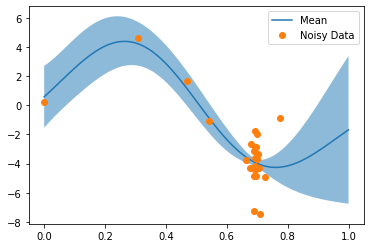

In [30]:
x1 = np.linspace(0.0, 1.0, 100)
m, v = gp3.predict(x1.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(x1, up, dwn, alpha=0.5)
plt.plot(x1, m, label="Mean")
plt.plot(x, y, 'o', label="Noisy Data")
plt.legend()

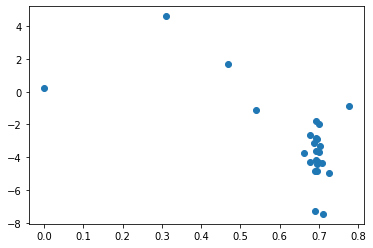

In [28]:
plt.plot(x, y, 'o')